In [724]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from HelperFunctions import *
import cvxpy as cp
from scipy.optimize import minimize
import multiprocessing as mp
import seaborn as sb
import L_S_decomp as lsd
from importlib import *
import HelperFunctions as hf

In [747]:
reload(hf)

<module 'HelperFunctions' from '/Users/Howard/Documents/MPS/CompIntMethods/project/HelperFunctions.py'>

In [2196]:
class nuc_norm_mc():
    def __init__(self, Y, O, lambda_, weighted=False, alpha=0.0):
        self.Y = Y
        self.obs_entries = O
        self.lambda_ = lambda_
        self.weighted = weighted
        self.alpha = alpha

    def objective(self, args):
        m,n = self.Y.shape
        obs_entries = self.obs_entries
        U, V = args[0], args[1]
        error = (np.nan_to_num(self.Y)-U@V)**2
        nuc_norm = np.tile(np.linalg.norm(U, axis=1)**2, (n,1)).T+np.tile(np.linalg.norm(V, axis=0)**2, (m,1))
        cost = np.multiply(obs_entries, error+self.lambda_*nuc_norm)
        return(np.sum(cost))

    def gradient(self, args):
        m,n = self.Y.shape
        obs_entries = self.obs_entries
        n_observed = np.sum(obs_entries)
        U, V = args[0], args[1]
        if self.weighted==False:
            self.alpha=0.0
        pr = 1/n_observed*(obs_entries.sum(axis=1)**self.alpha)[:,np.newaxis]
        pc = 1/n_observed*(obs_entries.sum(axis=0)**self.alpha)[np.newaxis,:]
        error = np.multiply((np.nan_to_num(self.Y)-U@V), obs_entries)
        dldu = -2*error@V.T+self.lambda_*U*pr
        dldv = -2*U.T@error+self.lambda_*V*pc
        return(dldu, dldv)
    
    def solve(self, learning_rate, max_iter, eps=0.01, rank=10):
        errs = []
        err = np.inf
        U = np.random.normal(0,1,(m,rank))
        V = np.random.normal(0,1,(rank,n))
        iter_ = 1
        while iter_ < max_iter and err > eps:
            err = np.linalg.norm(U@V-np.nan_to_num(self.Y))/np.linalg.norm(np.nan_to_num(self.Y))
            errs.append(err)
            du, dv = self.gradient((U,V))
            U = U - learning_rate*du
            V = V - learning_rate*dv
            iter_ += 1
        self.errs = errs
        return(U@V)
    

In [2111]:
lambdas = np.logspace(-2,3,5)
learning_rates = np.logspace(-4,-1,5)
def cross_validation(params, n_sets, lambdas = np.logspace(-3,1,5), learning_rates = np.logspace(-3,-1,5)):
    m, n, k, alpha, pct = params
    error_learning_rate = []
    for learning_rate in learning_rates:
        error_lambda = []
        for lambda_ in lambdas:
            error = []
            for i in range(n_sets):
                M = construct_matrix(m,n,k,alpha)
                M_obs = construct_partial_matrix(M, pct, method="uniform", alpha=0.1)
                nn_mc_uw = nuc_norm_mc(M_obs, lambda_, False)
                M_est_uw = nn_mc_uw.solve(learning_rate, 1000, 0.001)
                error.append(np.linalg.norm(M_est_uw-M)/np.linalg.norm(M))
            error_lambda.append(error)
        error_learning_rate.append(error_lambda)
    return(error_learning_rate)

def plot_grid_search(cv_res, x_param, y_param):
    sb.heatmap(np.nanmean(np.array(cv_res),axis=2), annot=True, \
               xticklabels=np.round(x_param,3), yticklabels=np.round(y_param,3))


In [823]:
res = cross_validation((m,n,k,0.1,0.7), 10, lambdas, learning_rates)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in matmul
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in matmul
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in matmul
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in matmul
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in multiply
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykern

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice


Text(0.5, 15.0, 'lambda')

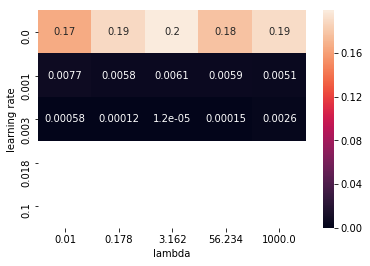

In [824]:
plot_grid_search(res, lambdas, learning_rates)
plt.ylabel("learning rate")
plt.xlabel("lambda")

# Experiment on relationship between lambda and observation rate

In [2171]:
learning_rate = 0.005
reps = 5
lambdas = np.logspace(-3,3,6)
pcts = np.arange(0.2, 1, 0.1)

error_pct = []
for pct in pcts:
    error_lambdas = []
    for lambda_ in lambdas:
        error = []
        for i in range(reps):
            M = construct_matrix(m,n,k,0)
            M_obs = construct_partial_matrix(M, pct, method="uniform", alpha=0.1)
            nn_mc_uw = nuc_norm_mc(M_obs, lambda_, False)
            M_est_uw = nn_mc_uw.solve(learning_rate, 1000, 0.001)
            error.append(np.linalg.norm(M_est_uw-M)/np.linalg.norm(M))
        error_lambdas.append(error)
    error_pct.append(error_lambdas)

Text(33.0, 0.5, 'pct')

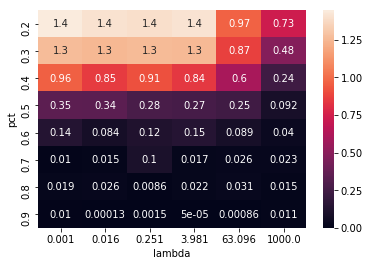

In [2172]:
plot_grid_search(error_pct, lambdas, pcts)
plt.xlabel("lambda")
plt.ylabel("pct")


Lambda effect with weighted version

In [2175]:
learning_rate = 0.005
reps = 5
lambdas = np.logspace(-3,3,6)
pcts = np.arange(0.2, 1, 0.1)

a_error_pct = []
for pct in pcts:
    a_error_lambdas = []
    for lambda_ in lambdas:
        error = []
        for i in range(reps):
            M = construct_matrix(m,n,k,0)
            M_obs = construct_partial_matrix(M, pct, method="uniform", alpha=0.1)
            nn_mc_w = nuc_norm_mc(M_obs, lambda_, True, alpha=1.0)
            M_est_w = nn_mc_w.solve(learning_rate, 1000, 0.001)
            error.append(np.linalg.norm(M_est_w-M)/np.linalg.norm(M))
        a_error_lambdas.append(error)
    a_error_pct.append(a_error_lambdas)

Text(33.0, 0.5, 'pct')

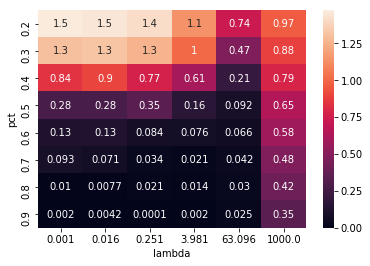

In [2176]:
plot_grid_search(a_error_pct, lambdas, pcts)
plt.xlabel("lambda")
plt.ylabel("pct")


In [2173]:
lambda_ = 0.3
learning_rate = 0.005
reps = 10
alphas = np.arange(0,1.2,0.2)
pcts = np.arange(0.2, 1, 0.1)

error_pct = []
for pct in pcts:
    error_alpha = []
    for alpha in alphas:
        error = []
        for i in range(reps):
            M = construct_matrix(m,n,k,alpha)
            M_obs = construct_partial_matrix(M, pct, method="uniform", alpha=0.1)
            nn_mc_uw = nuc_norm_mc(M_obs, lambda_, True, alpha=1.0)
            M_est_uw = nn_mc_uw.solve(learning_rate, 1000, 0.001)
            error.append(np.linalg.norm(M_est_uw-M)/np.linalg.norm(M))
        error_alpha.append(error)
    error_pct.append(error_alpha)


Text(33.0, 0.5, 'pct')

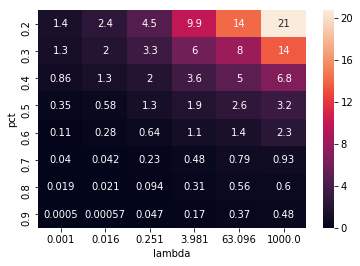

In [2174]:
plot_grid_search(error_pct, lambdas, pcts)
plt.xlabel("lambda")
plt.ylabel("pct")


# Experiment on coherence recovery rate.

Using uniform observation, we alter the coherence coefficient of the matrix 

In [831]:
lambda_ = 0.3
learning_rate = 0.005
reps = 10
alphas = np.arange(0,1.2,0.2)
pcts = np.arange(0.2, 1, 0.1)

error_pct = []
for pct in pcts:
    error_alpha = []
    for alpha in alphas:
        error = []
        for i in range(reps):
            M = construct_matrix(m,n,k,alpha)
            M_obs = construct_partial_matrix(M, pct, method="uniform", alpha=0.1)
            nn_mc_uw = nuc_norm_mc(M_obs, lambda_, False)
            M_est_uw = nn_mc_uw.solve(learning_rate, 1000, 0.001)
            error.append(np.linalg.norm(M_est_uw-M)/np.linalg.norm(M))
        error_alpha.append(error)
    error_pct.append(error_alpha)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in matmul
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in matmul
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in matmul
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in matmul
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in matmul
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipyk

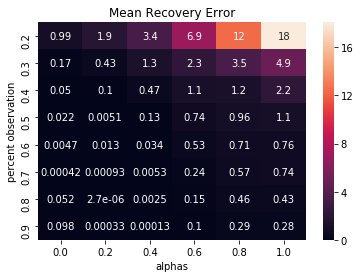

In [832]:
plot_grid_search(error_pct, alphas, pcts)
plt.xlabel("alphas")
plt.ylabel("percent observation")
plt.title("Mean Recovery Error")
plt.show()

# Experiment on matrix coherence with observation probability proportional to coherence.

How does the observation probability affect recovery rate.

In [894]:
lambda_ = 0.02
learning_rate = 0.005
reps = 10
alpha = 0.8
pcts = np.arange(0.2, 1, 0.1)

error_pct_nonuni = []
error_pct_uni = []
error_pct_lev = []
for pct in pcts:
    error_uni = []
    error_nonuni = []
    error_lev = []
    for i in range(reps):
        M = construct_matrix(m,n,k,alpha)
        M_obs_uni = construct_partial_matrix(M, pct, method="uniform")
        M_obs_nonuni = hf.construct_partial_matrix(M, pct, method="coherent")
        M_obs_lev = hf.construct_partial_matrix(M, pct, method="leverage", k=6)
    
        nn_mc_uni = nuc_norm_mc(M_obs_uni, lambda_, False)
        M_est_uni = nn_mc_uni.solve(learning_rate, 1000, 0.001)
        error_uni.append(np.linalg.norm(M_est_uni-M)/np.linalg.norm(M))
        
        nn_mc_nonuni = nuc_norm_mc(M_obs_nonuni, lambda_, False)
        M_est_nonuni = nn_mc_nonuni.solve(learning_rate, 1000, 0.001)
        error_nonuni.append(np.linalg.norm(M_est_nonuni-M)/np.linalg.norm(M))
         
        nn_mc_lev = nuc_norm_mc(M_obs_lev, lambda_, False)
        M_est_lev = nn_mc_lev.solve(learning_rate, 1000, 0.001)
        error_lev.append(np.linalg.norm(M_est_lev-M)/np.linalg.norm(M))
    error_pct_nonuni.append(error_nonuni)
    error_pct_uni.append(error_uni)
    error_pct_lev.append(error_lev)



# Observation patterns on different types of sampling schemes

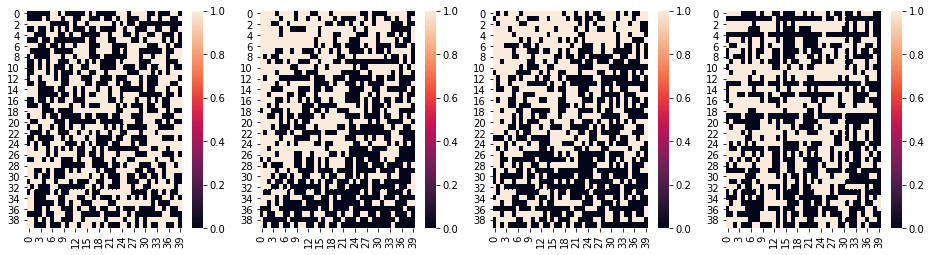

In [2170]:
M = construct_matrix(40,40,k,0.5)
pct=0.5
M_obs_uni = construct_partial_matrix(M, pct, method="uniform")
M_obs_nonuni = hf.construct_partial_matrix(M, pct, method="coherent")
M_obs_lev = hf.construct_partial_matrix(M, pct, method="leverage", k=10)
M_obs_dir = hf.construct_partial_matrix(M, pct, method="dir", alpha=2)

plt.subplots(figsize=(16,4))
plt.subplot(1,4,1)
sb.heatmap(~np.isnan(M_obs_uni))
plt.subplot(1,4,2)
sb.heatmap(~np.isnan(M_obs_nonuni))
plt.subplot(1,4,3)
sb.heatmap(~np.isnan(M_obs_lev))
plt.subplot(1,4,4)
sb.heatmap(~np.isnan(M_obs_dir))


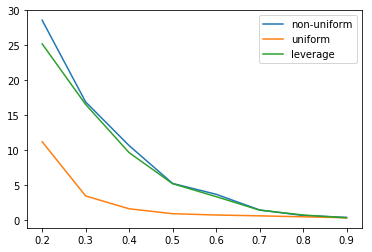

In [895]:
plt.plot(pcts, np.array(error_pct_nonuni).mean(axis=1), label="non-uniform")
plt.plot(pcts, np.array(error_pct_uni).mean(axis=1), label="uniform")
plt.plot(pcts, np.array(error_pct_lev).mean(axis=1), label="leverage")

plt.legend()

# Experiment on weighted vs unweighted nnm
observations are uniform

In [1230]:
m,n,k = 40, 40, 5

In [2126]:
lambda_ = 60
learning_rate = 0.005
reps = 10
alpha = 0.4
pcts = np.arange(0.2, 1, 0.1)

error_alpha_w = []
error_alpha_uw = []
for alpha in np.arange(0,1,0.2):
    error_pct_w = []
    error_pct_uw = []
    for pct in pcts:
        error_w = []
        error_uw = []
        for i in range(reps):
            M = construct_matrix(m,n,k,alpha)
            M_obs_uni = construct_partial_matrix(M, pct, method="uniform")

            nn_mc_w = nuc_norm_mc(M_obs_uni, lambda_, True, alpha=1)
            M_est_w = nn_mc_w.solve(learning_rate, 1000, 0.001, rank=15)
            error_w.append(np.linalg.norm(M_est_w-M)/np.linalg.norm(M))

            nn_mc_uw = nuc_norm_mc(M_obs_uni, lambda_, False)
            M_est_uw = nn_mc_uw.solve(learning_rate, 1000, 0.001, rank=15)
            error_uw.append(np.linalg.norm(M_est_uw-M)/np.linalg.norm(M))
        error_pct_w.append(error_w)
        error_pct_uw.append(error_uw)
    error_alpha_w.append(error_pct_w)
    error_alpha_uw.append(error_pct_uw)


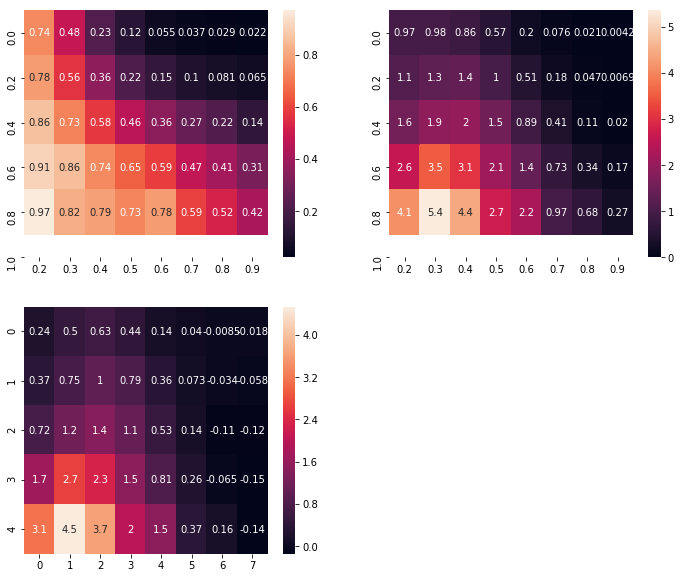

In [2145]:
plt.subplots(figsize=(12,10))
plt.subplot(2,2,1)
plot_grid_search(error_alpha_w,pcts, alphas)
plt.subplot(2,2,2)
plot_grid_search(error_alpha_uw,pcts, alphas)
plt.subplot(2,2,3)
sb.heatmap(np.array(error_alpha_uw).mean(axis=2)-np.array(error_alpha_w).mean(axis=2), annot=True)


Text(0.5, 1.0, 'Uniform Observation: Weighted vs. Unweighted MC')

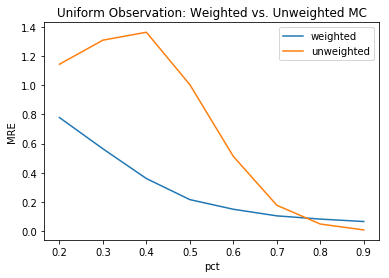

In [2167]:
a = 1
plt.plot(pcts, (np.array(error_alpha_w)[a,:,:]).mean(axis=1), label="weighted")
plt.plot(pcts, (np.array(error_alpha_uw)[a,:,:]).mean(axis=1), label="unweighted")
plt.legend()
plt.xlabel("pct")
plt.ylabel("MRE")
plt.title("Uniform Observation: Weighted vs. Unweighted MC")

Text(0.5, 1.0, 'Uniform Observation: MRE vs. alpha')

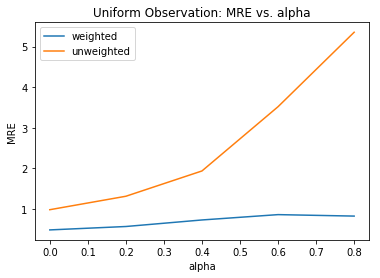

In [2169]:

plt.plot(np.arange(0,1,0.2), (np.array(error_alpha_w)[:,a,:]).mean(axis=1), label="weighted")
plt.plot(np.arange(0,1,0.2), (np.array(error_alpha_uw)[:,a,:]).mean(axis=1), label="unweighted")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("MRE")
plt.title("Uniform Observation: MRE vs. alpha")

Non-uniform observation weighted vs. unweighted

In [2178]:
lambda_ = 60
learning_rate = 0.005
reps = 10
alpha = 0.4
pcts = np.arange(0.2, 1, 0.1)

n_error_alpha_w = []
n_error_alpha_uw = []
for alpha in np.arange(0,1,0.2):
    error_pct_w = []
    error_pct_uw = []
    for pct in pcts:
        error_w = []
        error_uw = []
        for i in range(reps):
            M = construct_matrix(m,n,k,alpha)
            M_obs_dir = hf.construct_partial_matrix(M, pct, method="dir", alpha=2)

            nn_mc_w = nuc_norm_mc(M_obs_dir, lambda_, True, alpha=1)
            M_est_w = nn_mc_w.solve(learning_rate, 1000, 0.001, rank=15)
            error_w.append(np.linalg.norm(M_est_w-M)/np.linalg.norm(M))

            nn_mc_uw = nuc_norm_mc(M_obs_dir, lambda_, False)
            M_est_uw = nn_mc_uw.solve(learning_rate, 1000, 0.001, rank=15)
            error_uw.append(np.linalg.norm(M_est_uw-M)/np.linalg.norm(M))
        error_pct_w.append(error_w)
        error_pct_uw.append(error_uw)
    n_error_alpha_w.append(error_pct_w)
    n_error_alpha_uw.append(error_pct_uw)
    
    

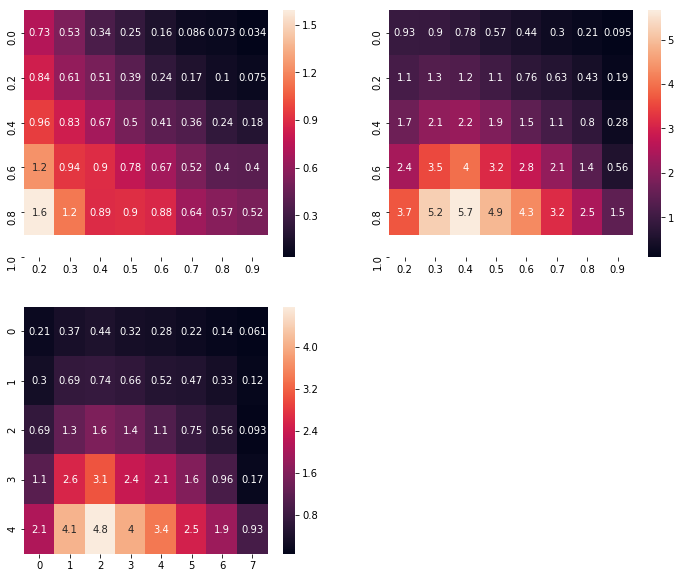

In [2179]:
plt.subplots(figsize=(12,10))
plt.subplot(2,2,1)
plot_grid_search(n_error_alpha_w,pcts, alphas)
plt.subplot(2,2,2)
plot_grid_search(n_error_alpha_uw,pcts, alphas)
plt.subplot(2,2,3)
sb.heatmap(np.array(n_error_alpha_uw).mean(axis=2)-np.array(n_error_alpha_w).mean(axis=2), annot=True)


Text(0.5, 1.0, 'Non-Uniform Observation: Weighted vs. Unweighted MC')

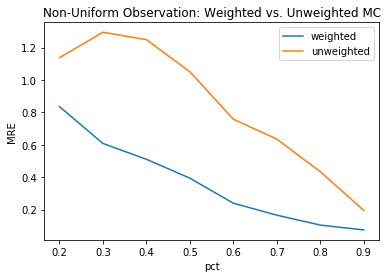

In [2184]:
a = 1
plt.plot(pcts, (np.array(n_error_alpha_w)[a,:,:]).mean(axis=1), label="weighted")
plt.plot(pcts, (np.array(n_error_alpha_uw)[a,:,:]).mean(axis=1), label="unweighted")
plt.legend()
plt.xlabel("pct")
plt.ylabel("MRE")
plt.title("Non-Uniform Observation: Weighted vs. Unweighted MC")

Text(0.5, 1.0, 'Non-Uniform Observation: MRE vs. alpha')

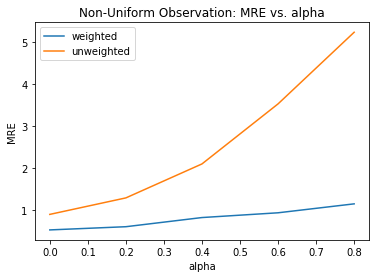

In [2185]:

plt.plot(np.arange(0,1,0.2), (np.array(n_error_alpha_w)[:,a,:]).mean(axis=1), label="weighted")
plt.plot(np.arange(0,1,0.2), (np.array(n_error_alpha_uw)[:,a,:]).mean(axis=1), label="unweighted")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("MRE")
plt.title("Non-Uniform Observation: MRE vs. alpha")

In [1270]:
learning_rate = 0.005
reps = 10
alpha = 0.1
pct = 0.5
lambdas = np.logspace(-2,2,5)

error_lambda_0 = []
error_lambda_1 = []
error_lambda_5 = []
error_lambda_10 = []


for lambda_ in lambdas:
    error_0 = []
    error_1 = []
    error_5 = []
    error_10 = []

    for i in range(reps):
        M = construct_matrix(m,n,k,alpha)
        M_obs_uni = construct_partial_matrix(M, pct, method="uniform")

        nn_mc = nuc_norm_mc(M_obs_uni, lambda_, True, alpha=0)
        M_est = nn_mc.solve(learning_rate, 1000, 0.001)
        error_0.append(np.linalg.norm(M_est-M)/np.linalg.norm(M))

        nn_mc = nuc_norm_mc(M_obs_uni, lambda_, True, alpha=0.1)
        M_est = nn_mc.solve(learning_rate, 1000, 0.001)
        error_1.append(np.linalg.norm(M_est-M)/np.linalg.norm(M))
        
        nn_mc = nuc_norm_mc(M_obs_uni, lambda_, True, alpha=0.5)
        M_est = nn_mc.solve(learning_rate, 1000, 0.001)
        error_5.append(np.linalg.norm(M_est-M)/np.linalg.norm(M))
        
        nn_mc = nuc_norm_mc(M_obs_uni, lambda_, True, alpha=1.0)
        M_est = nn_mc.solve(learning_rate, 1000, 0.001)
        error_10.append(np.linalg.norm(M_est-M)/np.linalg.norm(M))
    error_lambda_0.append(error_0)
    error_lambda_1.append(error_1)
    error_lambda_5.append(error_5)
    error_lambda_10.append(error_10)



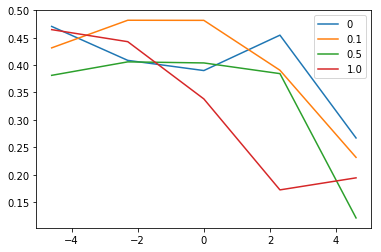

In [1271]:
plt.plot(np.log(lambdas), np.array(error_lambda_0).mean(axis=1), label="0")
plt.plot(np.log(lambdas), np.array(error_lambda_1).mean(axis=1), label="0.1")
plt.plot(np.log(lambdas), np.array(error_lambda_5).mean(axis=1), label="0.5")
plt.plot(np.log(lambdas), np.array(error_lambda_10).mean(axis=1), label="1.0")

plt.legend()

Cross Validation for lambda

In [982]:
lambda_ = 0.2
learning_rate = 0.005
reps = 10
alpha = 0.1
pcts = np.arange(0.2, 1, 0.1)

error_pct_w = []
error_pct_uw = []
for pct in pcts:
    error_lambda_w = []
    error_lambda_uw = []
    for lambda_ in lambdas:
        error_w = []
        error_uw = []
        for i in range(reps):
            M = construct_matrix(m,n,k,alpha)
            M_obs_uni = construct_partial_matrix(M, pct, method="dir", alpha=0.8)

            nn_mc_w = nuc_norm_mc(M_obs_uni, lambda_, True, alpha=0.9)
            M_est_w = nn_mc_w.solve(learning_rate, 1000, 0.001)
            error_w.append(np.linalg.norm(M_est_w-M)/np.linalg.norm(M))

            nn_mc_uw = nuc_norm_mc(M_obs_uni, lambda_, False)
            M_est_uw = nn_mc_uw.solve(learning_rate, 1000, 0.001)
            error_uw.append(np.linalg.norm(M_est_uw-M)/np.linalg.norm(M))
        error_lambda_w.append(error_w)
        error_lambda_uw.append(error_uw)
    error_pct_w.append(error_lambda_w)
    error_pct_uw.append(error_lambda_uw)


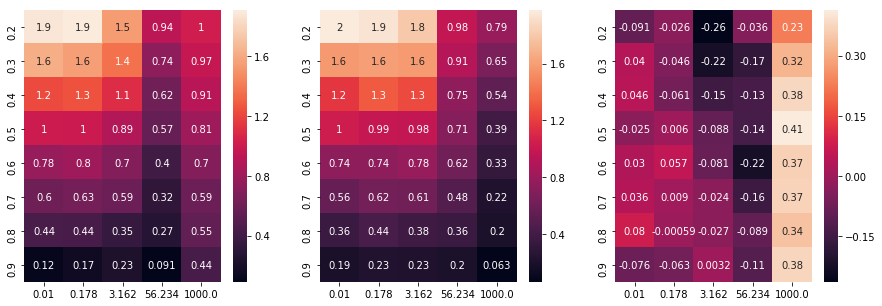

In [990]:
plt.subplots(figsize=(15,5))
plt.subplot(1,3,1)
plot_grid_search(error_pct_w, lambdas, pcts)
plt.subplot(1,3,2)
plot_grid_search(error_pct_uw, lambdas, pcts)
plt.subplot(1,3,3)
plot_grid_search(np.array(error_pct_w)-np.array(error_pct_uw), lambdas, pcts)

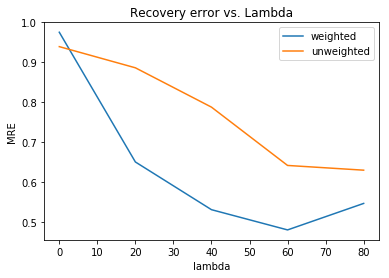

In [1046]:
plt.plot(lambdas, np.array(error_lambda_w).mean(axis=1), label="weighted")
plt.plot(lambdas, np.array(error_lambda_uw).mean(axis=1), label="unweighted")
plt.xlabel("lambda")
plt.ylabel("MRE")
plt.title("Recovery error vs. Lambda")
plt.legend()

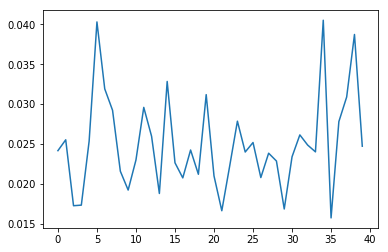

In [931]:
plt.plot(np.arange(n), np.random.dirichlet(np.ones(n)*20))

In [2442]:
def get_sparse_entries(M, alpha):
    #take the alpha% largest elements in each row and column
    m,n = M.shape
    row_quant = np.quantile(abs(M), alpha, axis=1)[:,np.newaxis]
    col_quant = np.quantile(abs(M), alpha, axis=0)[np.newaxis,:]
    S = np.multiply(M, abs(M) > row_quant)
    S = np.multiply(S, abs(M) > col_quant)
    return(S)

def get_sparse_cols(X, alpha):
    col_norm = np.linalg.norm(X, axis=0)[np.newaxis,:]
    sparse_cols= np.quantile(col_norm, alpha)
    X_thresh = X*np.multiply(col_norm, col_norm>=sparse_cols)
    return(X_thresh)

def sparse_matrix(m,n,sparse_pct,c, method="constant"):
    sparse_elements = np.random.uniform(0,1, (m,n))<=sparse_pct
    if method=="constant":
        S = np.multiply(np.sign(np.random.uniform(-1,1, (m,n)))*c, sparse_elements)
    else:
        S = np.multiply(np.random.uniform(-c,c, (m,n)), sparse_elements)
    return(S)

def sparse_col_matrix(M, gamma, s_pct, scale, l_pct, method="uniform", alpha=2.0):
    m,n = M.shape
    I = np.zeros((m,n))
    C = np.zeros((m,n))
    n_c_col = int(gamma*n)
    c_cols = np.random.choice(np.arange(n), n_c_col, replace=False)
    I[:,c_cols] = 1
    C[:,c_cols] = sparse_matrix(m, n_c_col, s_pct, scale)
    L = M
    L[:,c_cols] = 0
    L_obs = hf.construct_partial_matrix(M, l_pct, method, alpha=alpha)
    O = ~np.isnan(L_obs)
    return(L, C, I, O)

In [2539]:
class nuc_norm_mc_sparse():
    def __init__(self, Y, O,lambda_1, lambda_2, weighted=False, alpha=0.0):
        self.Y = Y
        self.obs_entries = O
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.weighted = weighted
        self.alpha = alpha

    def gradient(self, args):
        m,n = self.Y.shape
        obs_entries = self.obs_entries
        n_observed = np.sum(obs_entries)
        U, V, S = args[0], args[1], args[2]
        if self.weighted==False:
            self.alpha=0.0
        pu = 1/n_observed*(obs_entries.sum(axis=1)**self.alpha)[:,np.newaxis]
        pv = 1/n_observed*(obs_entries.sum(axis=0)**self.alpha)[np.newaxis,:]
        error = np.multiply((np.nan_to_num(self.Y)-U@V-S), obs_entries)
        dldu = -2*error@V.T+self.lambda_1*U*pu
        dldv = -2*U.T@error+self.lambda_1*V*pv
        dlds = -2*error+self.lambda_2*np.sign(S)
        return(dldu, dldv, dlds)
    
    def solve(self, learning_rate, max_iter, eps=0.01, rank=10, sparse_pct=0.5):
        errs = []
        err = np.inf
        U = np.random.normal(0,1,(m,rank))
        V = np.random.normal(0,1,(rank,n))
        S = np.zeros((m,n))
#         S = get_sparse_entries(np.multiply(np.nan_to_num(self.Y),self.obs_entries) , sparse_pct)
        iter_ = 1
        while iter_ < max_iter and err > eps:
            err = np.linalg.norm(U@V+S-np.nan_to_num(self.Y))/np.linalg.norm(np.nan_to_num(self.Y))
            errs.append(err)
            du, dv, ds = self.gradient((U,V,S))
            U = U - learning_rate*du
            du, dv, ds = self.gradient((U,V,S))
            V = V - learning_rate*dv
            du, dv, ds = self.gradient((U,V,S))
            S = get_sparse_cols(S - learning_rate*ds, sparse_pct)
#             print(S)
#             S = get_sparse_cols(np.multiply(np.nan_to_num(self.Y)-U@V,self.obs_entries), sparse_pct)
            iter_ += 1
#         S = get_sparse_cols(S, sparse_pct) 
        self.errs = errs
        return(U@V, S)

cross validation for lambda_2

In [2546]:
sparse_pct = 0.8
lambda_1 = 60
lambda_2 = 10
alpha = 0
learning_rate =0.01

M = construct_matrix(m,n,k,alpha)
L0, C0, I, O = sparse_col_matrix(M, 10/n, 0.99, 4, 0.7)
M_obs = np.multiply(L0+C0, O)
mu = 1/(np.linalg.norm(M_obs, axis=0).sum())
nnms = nuc_norm_mc_sparse(M_obs, O, lambda_1, lambda_2, weighted=False)
nnmw = nuc_norm_mc(M_obs, O, lambda_1, weighted=True, alpha=1.0)
Lw = nnmw.solve(learning_rate, 500, rank=10)
Lr, Cr = nnms.solve(learning_rate, 2000, sparse_pct=sparse_pct)
print(MRE_l(M, Lw, I))
print(MRE_l(M, Lr, I))
print(MRE_c(C0, Cr))

0.1420398674129403
0.11788426148178487
0.8


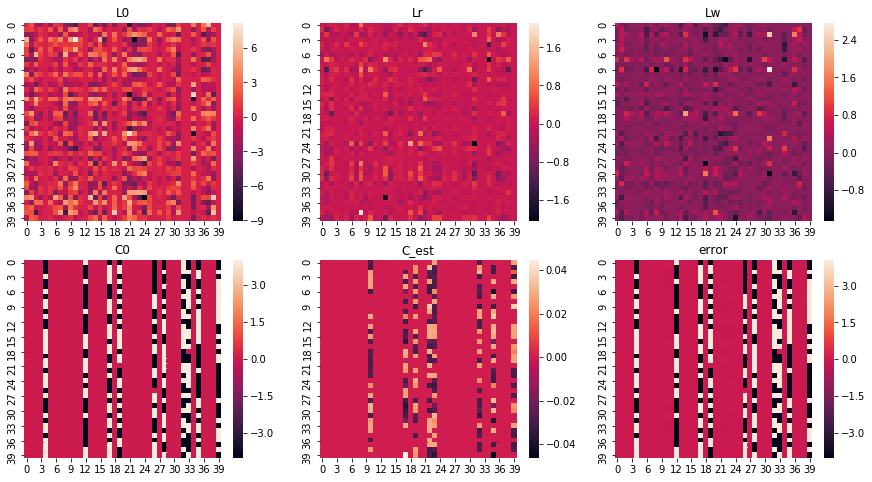

In [2547]:
plt.subplots(figsize=(15,8))
plt.subplot(2,3,1)
sb.heatmap(L0)
plt.title("L0")
plt.subplot(2,3,2)
sb.heatmap(np.multiply(Lr-L0, abs(I-1)))
plt.title("Lr")
plt.subplot(2,3,3)
sb.heatmap(np.multiply(Lw-L0, abs(I-1)))
plt.title("Lw")
plt.subplot(2,3,4)
sb.heatmap(C0)
plt.title("C0")
plt.subplot(2,3,5)
sb.heatmap(Cr)
plt.title("C_est")
plt.subplot(2,3,6)
plt.title("error")
sb.heatmap(C0-Cr)

In [2279]:
alpha = 0
lambda_2s = np.logspace(-1,2,10)
sparse_pcts = np.arange(0.6,0.9,0.1)

pct_error_l = []
pct_error_c = []
for sparse_pct in sparse_pcts:
    lambda_2_error_l = []
    lambda_2_error_c = []
    for lambda_2 in lambda_2s:
        error_l = []
        error_c = []
        for i in range(rep):
            M = construct_matrix(m,n,k,alpha)
            L0, C0, I, O = sparse_col_matrix(M, 5/n, 0.99, 3, 0.7)
            M_obs = np.multiply(L0+C0, O)
            nnms = nuc_norm_mc_sparse(M_obs, O, lambda_1, lambda_2, weighted=True, alpha=1.0)
            Lr, Cr = nnms.solve(learning_rate, 1000, sparse_pct=sparse_pct)
            error_l.append(MRE_l(M, Lr, I))
            error_c.append(MRE_c(C0, C))
        lambda_2_error_l.append(error_l)
        lambda_2_error_c.append(error_c)
    pct_error_l.append(lambda_2_error_l)
    pct_error_c.append(lambda_2_error_c)

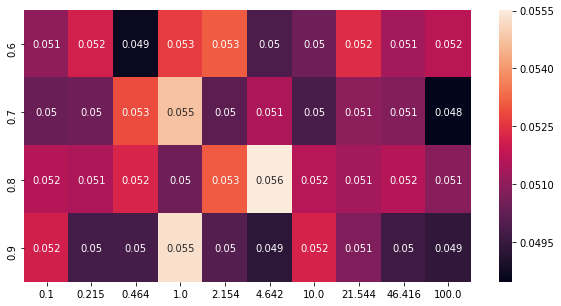

In [2283]:
plt.subplots(figsize=(10,5))
plot_grid_search(pct_error_l, lambda_2s, sparse_pcts)

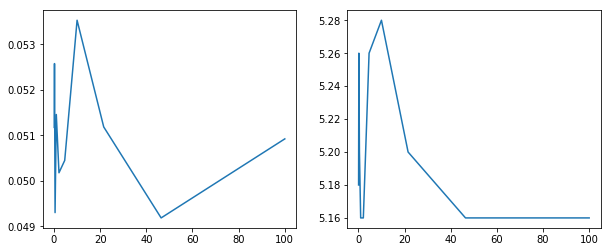

In [2255]:
plt.subplots(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(lambda_2s, np.array(lambda_2_error_l).mean(axis=1))
plt.subplot(1,2,2)
plt.plot(lambda_2s, np.array(lambda_2_error_c).mean(axis=1))

# Comparing robust vs. non-robust matrix completion

In [2239]:
def MRE_l(M, L, I):
    num = np.linalg.norm(np.multiply(L-M, abs(I-1)))
    den = np.linalg.norm(np.multiply(M, abs(I-1)))
    return(num/den)

def MRE_c(C0, C):
    I_c = np.where(np.linalg.norm(C0, axis=0)>0)
    I_c_est = np.where(np.linalg.norm(C, axis=0)>0)
    num = len(np.union1d(I_c, I_c_est))- len(np.intersect1d(I_c, I_c_est))
    den = len(I_c[0])
    return(num/den)

In [2425]:
learning_rate = 0.005
lambda_1 = 60
lambda_2 = 5
alpha = 0

m,n=40,40
n_c_cols = np.arange(0, 20, 5)

c_error_r = []
c_error_w = []
c_error_rw = []
for n_c_col in n_c_cols:
    sparse_pct = np.round(1-n_c_col/n)
    pct_error_r = []
    pct_error_w = []
    pct_error_rw = []
    for pct in pcts: 
        error_r = []
        error_w = []
        error_rw = []
        for i in range(rep):
            M = construct_matrix(m,n,k,alpha)
            L0, C0, I, O = sparse_col_matrix(M, n_c_col/n, 0.99, 4, 0.7)
            M_obs = np.multiply(L0+C0, O)
            mu = 1/(np.linalg.norm(M_obs, axis=0).sum())
            nnms = nuc_norm_mc_sparse(M_obs, O, lambda_1, lambda_2, weighted=False)
            nnmw = nuc_norm_mc(M_obs, O, lambda_1, weighted=True, alpha=1.0)
            nnmws = nuc_norm_mc_sparse(M_obs, O, lambda_1, lambda_2, weighted=True, alpha=1.0)
            Lw = nnmw.solve(learning_rate, 500, rank=10)
            Lr, Cr = nnms.solve(learning_rate, 500, sparse_pct=0.9)
            Lrw, Crw = nnmws.solve(learning_rate, 500, sparse_pct=0.9)
            error_r.append(MRE_l(M, Lr, I))
            error_w.append(MRE_l(M, Lw, I))
            error_rw.append(MRE_l(M, Lrw, I))
        pct_error_r.append(error_r)
        pct_error_w.append(error_w)
        pct_error_rw.append(error_rw)
    c_error_r.append(pct_error_r)
    c_error_w.append(pct_error_w)
    c_error_rw.append(pct_error_rw)



Text(0.5, 1.0, 'MRE vs. # corrupted columns')

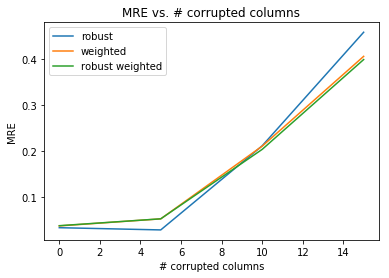

In [2431]:
a=6
plt.plot(n_c_cols, (np.array(c_error_r)[:,a,:]).mean(axis=1), label="robust")
plt.plot(n_c_cols, (np.array(c_error_w)[:,a,:]).mean(axis=1), label="weighted")
plt.plot(n_c_cols, (np.array(c_error_rw)[:,a,:]).mean(axis=1), label="robust weighted")

plt.legend()
plt.xlabel("# corrupted columns")
plt.ylabel("MRE")
plt.title("MRE vs. # corrupted columns")

Text(0.5, 1.0, 'MRE vs. pct')

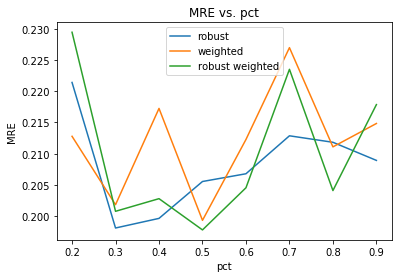

In [2433]:
a=2
plt.plot(pcts, (np.array(c_error_r)[a,:,:]).mean(axis=1), label="robust")
plt.plot(pcts, (np.array(c_error_w)[a,:,:]).mean(axis=1), label="weighted")
plt.plot(pcts, (np.array(c_error_rw)[a,:,:]).mean(axis=1), label="robust weighted")

plt.legend()
plt.xlabel("pct")
plt.ylabel("MRE")
plt.title("MRE vs. pct")

In [2434]:
learning_rate = 0.005
lambda_1 = 60
lambda_2 = 5
alpha = 0

m,n=40,40
n_c_cols = np.arange(0, 20, 5)

c_error_r = []
c_error_w = []
c_error_rw = []
for n_c_col in n_c_cols:
    sparse_pct = np.round(1-n_c_col/n)
    pct_error_r = []
    pct_error_w = []
    pct_error_rw = []
    for pct in pcts: 
        error_r = []
        error_w = []
        error_rw = []
        for i in range(rep):
            M = construct_matrix(m,n,k,alpha)
            L0, C0, I, O = sparse_col_matrix(M, n_c_col/n, 0.99, 4, 0.7, method="dir")
            M_obs = np.multiply(L0+C0, O)
            mu = 1/(np.linalg.norm(M_obs, axis=0).sum())
            nnms = nuc_norm_mc_sparse(M_obs, O, lambda_1, lambda_2, weighted=False)
            nnmw = nuc_norm_mc(M_obs, O, lambda_1, weighted=True, alpha=1.0)
            nnmws = nuc_norm_mc_sparse(M_obs, O, lambda_1, lambda_2, weighted=True, alpha=1.0)
            Lw = nnmw.solve(learning_rate, 500, rank=10)
            Lr, Cr = nnms.solve(learning_rate, 500, sparse_pct=0.9)
            Lrw, Crw = nnmws.solve(learning_rate, 500, sparse_pct=0.9)
            error_r.append(MRE_l(M, Lr, I))
            error_w.append(MRE_l(M, Lw, I))
            error_rw.append(MRE_l(M, Lrw, I))
        pct_error_r.append(error_r)
        pct_error_w.append(error_w)
        pct_error_rw.append(error_rw)
    c_error_r.append(pct_error_r)
    c_error_w.append(pct_error_w)
    c_error_rw.append(pct_error_rw)


Text(0.5, 1.0, 'MRE vs. # corrupted columns')

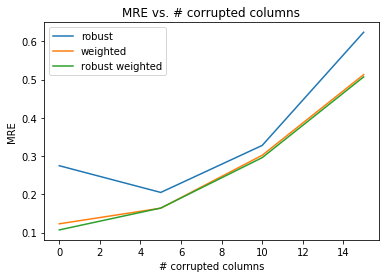

In [2437]:
a=5
plt.plot(n_c_cols, (np.array(c_error_r)[:,a,:]).mean(axis=1), label="robust")
plt.plot(n_c_cols, (np.array(c_error_w)[:,a,:]).mean(axis=1), label="weighted")
plt.plot(n_c_cols, (np.array(c_error_rw)[:,a,:]).mean(axis=1), label="robust weighted")

plt.legend()
plt.xlabel("# corrupted columns")
plt.ylabel("MRE")
plt.title("MRE vs. # corrupted columns")

Text(0.5, 1.0, 'MRE vs. # corrupted columns')

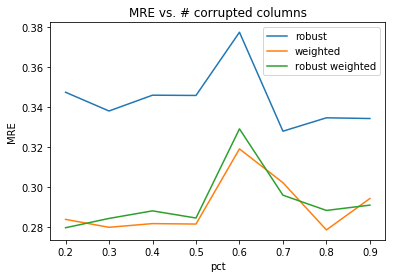

In [2440]:
a=2
plt.plot(pcts, (np.array(c_error_r)[a,:,:]).mean(axis=1), label="robust")
plt.plot(pcts, (np.array(c_error_w)[a,:,:]).mean(axis=1), label="weighted")
plt.plot(pcts, (np.array(c_error_rw)[a,:,:]).mean(axis=1), label="robust weighted")

plt.legend()
plt.xlabel("pct")
plt.ylabel("MRE")
plt.title("MRE vs. # corrupted columns")

In [1967]:
learning_rate = 0.005
reps = 10
alpha = 0.1

lambda_1s =  np.logspace(1,3,7)
lambda_2s = np.logspace(-3,1,7)
lambda1_error_S = []
lambda1_error_L = []
for lambda_1 in lambda_1s:
    lambda2_error_S = []
    lambda2_error_L = []
    for lambda_2 in lambda_2s:
        error_S = []
        error_L = []
        for i in range(rep):
            L0 = construct_matrix(m,n,k,alpha)
            S0 = sparse_matrix(m,n,0.05,1)
            M = L0+S0
            M_obs_uni = construct_partial_matrix(M, 1.0, method="uniform")
            nnms = nuc_norm_mc_sparse(M_obs_uni, lambda_1, lambda_2, weighted=True, alpha=1.0)
            L, S = nnms.solve(learning_rate, 1000, 0.001, sparse_pct=1.0)
            error_S.append(np.linalg.norm(S-S0)/np.linalg.norm(S0))
            error_L.append(np.linalg.norm(L-L0)/np.linalg.norm(L0))
        lambda2_error_S.append(error_S)
        lambda2_error_L.append(error_L)
    lambda1_error_S.append(lambda2_error_S)
    lambda1_error_L.append(lambda2_error_L)

TypeError: __init__() missing 1 required positional argument: 'lambda_2'

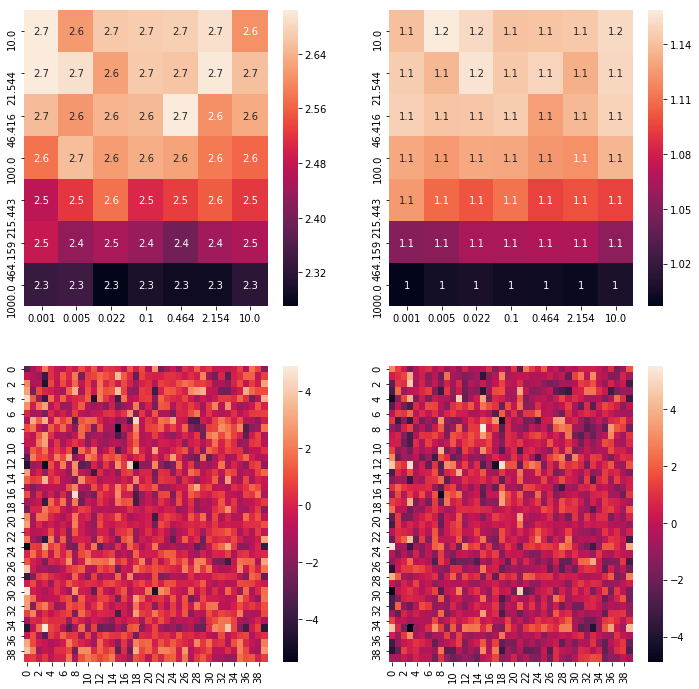

In [1314]:
plt.subplots(figsize=(12,12))
plt.subplot(2,2,1)
plot_grid_search(lambda1_error_S, lambda_2s, lambda_1s)
plt.subplot(2,2,2)
plot_grid_search(lambda1_error_L, lambda_2s, lambda_1s)
plt.subplot(2,2,3)
sb.heatmap(L-L0)
plt.subplot(2,2,4)
sb.heatmap(S-S0)

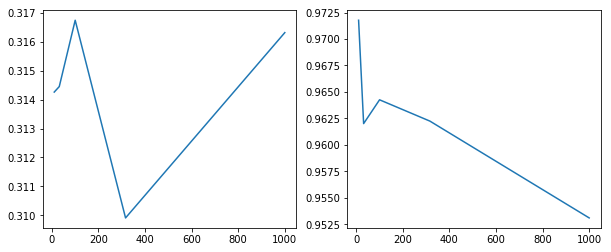

In [1214]:
plt.subplots(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(lambda_2s, np.array(lambda2_error_S).mean(axis=1))
plt.subplot(1,2,2)
plt.plot(lambda_2s, np.array(lambda2_error_L).mean(axis=1))

In [2032]:

    
def shrinkage(tau, X):
    r = np.multiply(np.sign(X), np.maximum(np.abs(X)-tau, 0))
    return(r)

def cw_softthresh(X, eps):
    col_norm = np.linalg.norm(X, axis=0)[np.newaxis,:]
    X_thresh = X - eps*X/col_norm
    X_thresh = X_thresh*np.multiply(col_norm, col_norm>=eps)
    return(X_thresh)
    
def ew_softthresh(X, eps):
    X_thresh = X - eps*np.sign(X)
    X_thresh = np.multiply(X_thresh, abs(X)>=eps)
    return(X_thresh)
    
def sv_srinkage(X, eps):
    u,s,v = np.linalg.svd(X, full_matrices=False)
    r = u@np.diag(ew_softthresh(s, eps))@v
    return(r)

def alm(M, O, lambda_, mu, eps=0.001, max_iter=500, alpha=1):
    m,n = M.shape
    obs_entries = O
    normM = np.linalg.norm(M, "fro")
    err = np.inf
    
    Y = np.zeros((m,n))
    L = np.zeros((m,n))
    C = np.zeros((m,n))
    E = np.zeros((m,n))
    
    iter_ = 1
    while iter_ < max_iter and err > eps:
        L = sv_srinkage(M-E-C+1/mu*Y, 1/mu)
        C = cw_softthresh(M-E-L+1/mu*Y, lambda_/mu)
        E = np.multiply(M-L-C+1/mu*Y, ~obs_entries)
        Y = Y + mu*(M-E-L-C)
        mu = alpha*mu
        
        err = np.linalg.norm(M-L-C-E, "fro")/normM
        iter_ += 1
    print(lambda_/mu)
    return(L,C,Y,E)

def sparse_mc_err(L, L0, S, S0, I):
    np.linalg.norm(np.multiply(L-L0, abs(I-1)))/np.linalg.norm(np.multiply(L0,abs(I-1)))
    np.linalg.norm(S-S0)/np.linalg.norm(S0)

In [2049]:
m,n=40,40
M = construct_matrix(m,n,k,0)
L0, C0, I, O = sparse_col_matrix(M, 10/n, 0.99, 5, 0.7)
M_obs = np.multiply(L0+C0, O)
mu = 1/(np.linalg.norm(M_obs, axis=0).sum())
print(mu)
mu = mu**(10/10)

0.0016396596761713625


In [2050]:
lambda_ = 0.9999
L,C,Y,E = alm(M_obs, O, lambda_, mu, alpha=1.5, eps=0.0001)

0.024150235811143672


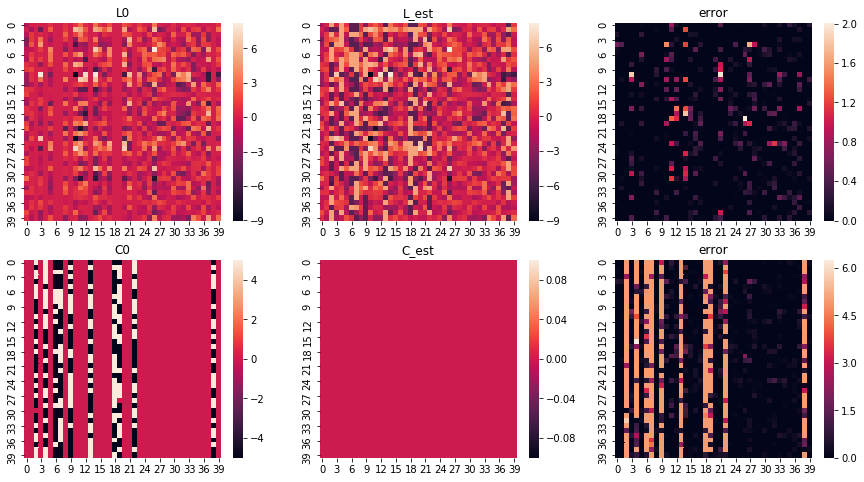

In [2053]:
plt.subplots(figsize=(15,8))
plt.subplot(2,3,1)
sb.heatmap(L0)
plt.title("L0")
plt.subplot(2,3,2)
sb.heatmap(L)
plt.title("L_est")
plt.subplot(2,3,3)
plt.title("error")
sb.heatmap(np.multiply(abs(M-L),abs(I-1)))
plt.subplot(2,3,4)
sb.heatmap(C0)
plt.title("C0")
plt.subplot(2,3,5)
sb.heatmap(C)
plt.title("C_est")
plt.subplot(2,3,6)
plt.title("error")
sb.heatmap(abs(M-L-C))